# Text Analytics on Asheville, NC AirBnb reviews
- With lots of help from "Text Analytics with Python" by Dipanjan Sarkar
- Data has reviews from 2010-10-28  to  2019-07-25 for 2,026 listings and 146,773 total reviews

In [2]:
import pandas as pd
import numpy as np
import os
import gensim
import nltk
import re
import string
import nltk
import numpy
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

#Read in Data
df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\airbnb.csv")
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comment_tok
0,38585,129120,2010-10-28,55877,Ritchie,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting.,"['evelyne', 'accommodating', 'host', 'lives', 'beautiful', 'rural', 'area', 'outside', 'asheville', 'recommend', 'staying', 'looking', 'peace', 'quiet', 'natural', 'setting']"
1,38585,147273,2010-11-30,279973,Cathy,Evelyne was very welcoming to her home; my friend and I enjoyed her company as well as our trip to asheville.,"['evelyne', 'welcoming', 'home', 'friend', 'enjoyed', 'company', 'well', 'trip', 'asheville']"
2,38585,198797,2011-03-14,411638,NaN,"I really enjoyed Evelyne's welcoming and bubbly personality and was more ""wowed"" by the beautiful house and scenery than I expected to be. Even Zoe was good company. Also enjoyed the organic th...","['really', 'enjoyed', 'evelynes', 'welcoming', 'bubbly', 'personality', 'wowed', 'beautiful', 'house', 'scenery', 'expected', 'even', 'zoe', 'good', 'company', 'also', 'enjoyed', 'organic', 'theme..."
3,38585,201932,2011-03-17,441855,Bill,Very gracious host and was helpful in all aspects of finding her home and information about Ashville.,"['gracious', 'host', 'helpful', 'aspects', 'finding', 'home', 'information', 'ashville']"
4,38585,341616,2011-06-28,657560,Joakim,Evelyn was very friendly and easy to comunicate with. the hous was very clean and he made us breakfast with tea from her own garden wich tasted really good. Nice stay.,"['evelyn', 'friendly', 'easy', 'comunicate', 'hous', 'clean', 'made', 'us', 'breakfast', 'tea', 'garden', 'wich', 'tasted', 'really', 'good', 'nice', 'stay']"


# Create DataFrame for comments combined for each listing_id

In [3]:
#Read in Data
#df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\airbnb.csv")

#Group by listing_id
grouped = df.groupby('listing_id')

#Create new dataframe
group_df = pd.DataFrame(columns = ['listing_id', 'comments'])

#Loop through each listing_id and collpase reviews into 1 observation per listing
index = 0
for i in np.unique(df.listing_id):
    group = grouped.get_group(i)
    comments = group.comments.apply(str)
    comments = ' '.join(comments)
    group_df.loc[index] = [i, comments]
    index = index+1

display(group_df.head())

# Read in the dataframe that's already grouped
#group_df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\grouped_airbnb.csv")
df = group_df

,listing_id,comments
0,38585,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne ...
1,80905,"Celeste is an accommodating and gracious host. We didn't get a chance to do any cooking, but the kitchen is really set up well for guests who want to cook. Great mattress! Very nice interior and C..."
2,108061,"Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Ec..."
3,155305,"We had a wonderful time! The cottage was very comfortable, although the bed could use a box spring or some extra support. Place was great! Can't really speak to the inside as we only went inside ..."
4,156805,Cool place. Nice folks. Good location. They were very rapid in their response and in helping finding a place to stay even when they were full. Thanks!! Great people and great location. My wife an...


# Look at the reviews

In [5]:
# Create list of all reviews and take a look at the first one
reviews = []
for review in df.comments:
    reviews.append(review)
print(len(reviews))
print(reviews[0][:500])

2026
Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne was very welcoming to her home; my friend and I enjoyed her company as well as our trip to asheville. I really enjoyed Evelyne's welcoming and bubbly personality and was more "wowed" by the beautiful house and scenery than I expected to be.   Even Zoe was good company.  Also enjoyed the organic theme an


# Text Wrangling

In [6]:
# Create function to remove stop words and any terms having a single character
def normalize_corpus(reviews):
    stop_words = nltk.corpus.stopwords.words('english')
    wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    norm_local_reviews = []
    for review in reviews:
        review = review.lower()
        review_tokens = [token.strip() for token in wtk.tokenize(review)]
        review_tokens = [wnl.lemmatize(token) for token in review_tokens if not token.isnumeric()]
        review_tokens = [token for token in review_tokens if len(token) > 1]
        review_tokens = [token for token in review_tokens if token not in stop_words]
        review_tokens = list(filter(None, review_tokens))
        if review_tokens:
            norm_local_reviews.append(review_tokens)
    return(norm_local_reviews)

norm_reviews = normalize_corpus(reviews)
print(len(norm_reviews))

#Check a processed review
print(norm_reviews[0][:100])

2026
['evelyne', 'accommodating', 'host', 'life', 'beautiful', 'rural', 'area', 'outside', 'asheville', 'recommend', 'staying', 'looking', 'peace', 'quiet', 'natural', 'setting', 'evelyne', 'wa', 'welcoming', 'home', 'friend', 'enjoyed', 'company', 'well', 'trip', 'asheville', 'really', 'enjoyed', 'evelyne', 'welcoming', 'bubbly', 'personality', 'wa', 'wowed', 'beautiful', 'house', 'scenery', 'expected', 'even', 'zoe', 'wa', 'good', 'company', 'also', 'enjoyed', 'organic', 'theme', 'left', 'feeling', 'vibrant', 'healthier', 'would', 'definitely', 'stay', 'thanks', 'evelyne', 'gracious', 'host', 'wa', 'helpful', 'aspect', 'finding', 'home', 'information', 'ashville', 'evelyn', 'wa', 'friendly', 'easy', 'comunicate', 'hous', 'wa', 'clean', 'made', 'breakfast', 'tea', 'garden', 'wich', 'tasted', 'really', 'good', 'nice', 'stay', 'evelyne', 'wa', 'gracious', 'inviting', 'friendly', 'hostess', 'well', 'informed', 'place', 'eat', 'asheville', 'got', 'great', 'direction', 'get', 'place', 'zoe

# Topic Models with Gensim

In [7]:
bigram = gensim.models.Phrases(norm_reviews, min_count=20, threshold=20, delimiter = b'_') #create a higher threshold for fewer phrases
bigram_model = gensim.models.phrases.Phraser(bigram)

#Sample look into the model (two-word phrases made up of two words separated by an underscore)
print(bigram_model[norm_reviews[0][:200]])

['evelyne', 'accommodating', 'host', 'life', 'beautiful', 'rural', 'area', 'outside', 'asheville', 'recommend', 'staying', 'looking', 'peace', 'quiet', 'natural', 'setting', 'evelyne', 'wa', 'welcoming', 'home', 'friend', 'enjoyed', 'company', 'well', 'trip', 'asheville', 'really', 'enjoyed', 'evelyne', 'welcoming', 'bubbly', 'personality', 'wa', 'wowed', 'beautiful', 'house', 'scenery', 'expected', 'even', 'zoe', 'wa', 'good', 'company', 'also', 'enjoyed', 'organic', 'theme', 'left', 'feeling', 'vibrant', 'healthier', 'would', 'definitely', 'stay', 'thanks', 'evelyne', 'gracious', 'host', 'wa', 'helpful', 'aspect', 'finding', 'home', 'information', 'ashville', 'evelyn', 'wa', 'friendly', 'easy', 'comunicate', 'hous', 'wa', 'clean', 'made', 'breakfast', 'tea', 'garden', 'wich', 'tasted', 'really', 'good', 'nice', 'stay', 'evelyne', 'wa', 'gracious', 'inviting', 'friendly', 'hostess', 'well', 'informed', 'place', 'eat', 'asheville', 'got', 'great', 'direction', 'get', 'place', 'zoe', 'c

In [8]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_reviews]

#Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'ability'), (1, 'able'), (2, 'abode'), (3, 'absolutely'), (4, 'abundant'), (5, 'access'), (6, 'accommodated'), (7, 'accommodating'), (8, 'accommodation'), (9, 'accompanied'), (10, 'accompanies'), (11, 'accompany'), (12, 'accompanying'), (13, 'accomplished'), (14, 'accurate')]
Total Vocabulary Size: 26981


In [9]:
# Filter out words that occur less than 20 documents, or more than 60% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Reduced Vocabulary Size:', len(dictionary))

Total Reduced Vocabulary Size: 5030


In [10]:
#Transform the coprus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

print()

# Look at the actual temrs and their counts
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

print()

#Check total papers in the corpus to make sure all are there
print('Total number of papers:', len(bow_corpus))

[(3, 1), (4, 4), (7, 1), (8, 1), (11, 1), (15, 2), (21, 1), (26, 3), (31, 1), (32, 1), (33, 2), (38, 1), (40, 2), (42, 2), (44, 3), (49, 1), (50, 1), (51, 1), (56, 1), (69, 1), (71, 1), (72, 1), (74, 1), (78, 6), (79, 1), (80, 2), (84, 2), (88, 1), (90, 2), (101, 1), (103, 1), (109, 2), (110, 2), (122, 2), (124, 1), (130, 5), (134, 1), (135, 1), (141, 1), (142, 2), (143, 1), (146, 1), (152, 2), (155, 1), (162, 1), (164, 1), (167, 4), (169, 8), (180, 1), (190, 1)]

[('accommodated', 1), ('accommodation', 4), ('accurate', 1), ('active', 1), ('added', 1), ('advice', 2), ('allow', 1), ('always', 3), ('anyone', 1), ('anyone_visiting', 1), ('anything', 2), ('appreciate', 1), ('arrival', 2), ('arrived', 2), ('art', 3), ('ask', 1), ('asked', 1), ('asked_better', 1), ('atmosphere', 1), ('base', 1), ('bbq', 1), ('beautifully', 1), ('bedroom', 1), ('better', 6), ('big', 1), ('biltmore', 2), ('bit', 2), ('book', 1), ('booking', 2), ('bunch', 1), ('busy', 1), ('came', 2), ('car', 2), ('checked', 2)

# Scikit Learn BOW, TF-IDF, and LDA

# Bag of Words Model

In [10]:
#Building corpus of documents (a collection of text documents usually belonging to one or more topics)
corpus = df.comments
corpus = np.array(corpus)
corpus_df=pd.DataFrame({'Document': corpus})
corpus_df = corpus_df[['Document']]
corpus_df

,Document
0,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne ...
1,"Celeste is an accommodating and gracious host. We didn't get a chance to do any cooking, but the kitchen is really set up well for guests who want to cook. Great mattress! Very nice interior and C..."
2,"Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Ec..."
3,"We had a wonderful time! The cottage was very comfortable, although the bed could use a box spring or some extra support. Place was great! Can't really speak to the inside as we only went inside ..."
4,Cool place. Nice folks. Good location. They were very rapid in their response and in helping finding a place to stay even when they were full. Thanks!! Great people and great location. My wife an...
5,Arrived around 4PM and greeted very warmly. Really close to a lot of cool West Asheville attractions. Rooms were comfortable and clean. Bathroom was clean as well. Definitely recommend it to other...
6,"My husband and I had a wonderful time with Elizabeth, Hutch, and their family! They were such gracious hosts and we would recommend them to anyone looking for a beautiful and comfortable place to ..."
7,"Amy and Ken were fabulous hosts. They had lots of suggestions on what to do around Asheville. The location is superb, walk 2 blocks and you're surrounded by restaurants, galleries, and bakeries. T..."
8,Absolutely enjoyed our stay w/ Kevin and Anne..The neighborhood was idyllic and beautiful. The cottage perfectly clean and orderly. Downtown about a mile away. Very helpful and accomodating hosts....
9,"I had an awesome time at Susanne's place! Her house is in a very nice, quiet area, but still only minutes away from trendy West Asheville with bars, coffee shops etc, and there are also some deli..."


In [11]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    #lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    #tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

#Apply the pre-processing function to the documents
norm_corpus = normalize_corpus(corpus)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

#View non-zero feature positions in the sparse matrix
#print(cv_matrix)

#View dense representation 
#warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()

#Get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
#pd.DataFrame(cv_matrix, columns = vocab).iloc[:,500:560]

,abase,abatement,abb,abbers,abbey,abbiamo,abbie,abbreviated,abby,abc,...,abrazo,abreast,abroad,abrupt,abruptly,abs,abselutely,absence,absent,absol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

tt = TfidfTransformer(norm = 'l2', use_idf=True)
tt_matrix = tt.fit_transform(cv_matrix)

tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()

# Show TF_IDF model based document feature vectors
#pd.DataFrame(np.round(tt_matrix, 2), columns = vocab).iloc[:,500:560]

,abase,abatement,abb,abbers,abbey,abbiamo,abbie,abbreviated,abby,abc,...,abrazo,abreast,abroad,abrupt,abruptly,abs,abselutely,absence,absent,absol
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [21]:
# Using TfidfVectorizer instead of the Bag of Words model
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                    use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()

# Show TF_IDF model based document feature vectors (same process as above)
#pd.DataFrame(np.round(tv_matrix, 2), columns=vocab).iloc[:, 500:560]

,abase,abatement,abb,abbers,abbey,abbiamo,abbie,abbreviated,abby,abc,...,abrazo,abreast,abroad,abrupt,abruptly,abs,abselutely,absence,absent,absol
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


# Document Similarity

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,109,1878,0,2
1,1901,2026,0,3
2,614,784,0.0913756,2
3,96,97,0.135606,2
4,151,155,0.17,2
5,19,23,0.187715,2
6,843,847,0.188349,2
7,264,568,0.218292,2
8,661,716,0.220234,2
9,44,72,0.237487,2


,Document,ClusterLabel
0,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne ...,1
1,"Celeste is an accommodating and gracious host. We didn't get a chance to do any cooking, but the kitchen is really set up well for guests who want to cook. Great mattress! Very nice interior and C...",2
2,"Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Ec...",7
3,"We had a wonderful time! The cottage was very comfortable, although the bed could use a box spring or some extra support. Place was great! Can't really speak to the inside as we only went inside ...",7
4,Cool place. Nice folks. Good location. They were very rapid in their response and in helping finding a place to stay even when they were full. Thanks!! Great people and great location. My wife an...,7
5,Arrived around 4PM and greeted very warmly. Really close to a lot of cool West Asheville attractions. Rooms were comfortable and clean. Bathroom was clean as well. Definitely recommend it to other...,7
6,"My husband and I had a wonderful time with Elizabeth, Hutch, and their family! They were such gracious hosts and we would recommend them to anyone looking for a beautiful and comfortable place to ...",5
7,"Amy and Ken were fabulous hosts. They had lots of suggestions on what to do around Asheville. The location is superb, walk 2 blocks and you're surrounded by restaurants, galleries, and bakeries. T...",3
8,Absolutely enjoyed our stay w/ Kevin and Anne..The neighborhood was idyllic and beautiful. The cottage perfectly clean and orderly. Downtown about a mile away. Very helpful and accomodating hosts....,3
9,"I had an awesome time at Susanne's place! Her house is in a very nice, quiet area, but still only minutes away from trendy West Asheville with bars, coffee shops etc, and there are also some deli...",3


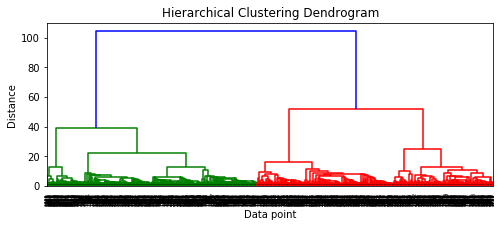

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)

#Look at the pairwise document cosine similarites 
#display(similarity_df)

##################### Document Clustering with Similarity Features ##############################
from scipy.cluster.hierarchy import dendrogram, linkage

#Agglomerative clustering, which is hierarchical clustering using a bottom-up approach
# Bottom-up means each doc starts in its own cluster and clusters are merged using Ward's method as a linkage merge criterion
# In this chunk, we use Ward's minimum variance method as our linkage criterion to minimize total within-cluster variance
Z = linkage(similarity_matrix, 'ward')

# Display linkage matrix for our corpus
display(pd.DataFrame(Z, columns = ['Document\Cluster 1', 'Document\Cluster 2', 
                          'Distance', 'Cluster Size'], dtype = 'object'))

#Let's visualize this clustering process
plt.figure(figsize=(8,3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

# Decide a threshold for the distance metric to get the cluster labels
from scipy.cluster.hierarchy import fcluster
max_dist = 14 #This is the threshold

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns = ['ClusterLabel'])
doc_clusters = pd.concat([corpus_df, cluster_labels], axis=1)
display(doc_clusters)

In [30]:
np.max(doc_clusters.ClusterLabel)

7

In [34]:
corpus_df.Document[2]

'Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Eco-retreat, the Private sunny apartment is a neat little flat with all you need for up to 3 people, the place was impeccable in lovely neighborhood. You can hardly beat this one! This was a lovely little place walking distance from downtown. Lisa was very responsive. My best Airbnb experience yet! Lisa was very nice to work with.  However, we didn\'t realize that the house was so old.  Normally that would have been okay, but in this case, it meant that the floor above us (where the permanent renters lived) was VERY squeaky.  The first night we stayed there, we couldn\'t sleep for a while because the people above us were walking around at 3am.  We didn\'t hear them walking around the next night, but we did the third night.\r\nThe apartment was very cute and clean.  It had everything that we nee

# LDA with Scikit_Learn

In [26]:
# Use Scikit_Learn to get document-topic matrix
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 5,
                               max_iter=10000,
                               random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix,
                       columns = ['T{}'.format(i) for i in range(1, 5+1)])
#features

# Latent Dirichlet Allocation (LDA) with Gensim

In [272]:
TOTAL_TOPICS = 8

In [273]:
lda_model8 = gensim.models.LdaModel(corpus=bow_corpus, id2word = dictionary,
                                  chunksize=1740, alpha='auto',
                                  eta='auto', random_state=42,
                                  iterations=500, num_topics = TOTAL_TOPICS,
                                  passes = 20, eval_every=None)

In [274]:
# Print each topic
for topic_id, topic in lda_model8.print_topics(num_topics=TOTAL_TOPICS, num_words=50):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.050*"laura" + 0.033*"josh" + 0.029*"tom" + 0.028*"paul" + 0.027*"katie" + 0.022*"jennifer" + 0.009*"jason" + 0.007*"shower" + 0.006*"west" + 0.006*"thomas" + 0.005*"bedroom" + 0.005*"smell" + 0.005*"dog" + 0.005*"maggie" + 0.005*"thoughtful" + 0.005*"left" + 0.004*"snack" + 0.004*"smoke" + 0.004*"water" + 0.004*"fridge" + 0.004*"anything" + 0.003*"far" + 0.003*"relaxing" + 0.003*"local_beer" + 0.003*"welcoming" + 0.003*"kind" + 0.003*"quick_respond" + 0.003*"use" + 0.003*"peaceful" + 0.003*"question" + 0.003*"mountain" + 0.003*"outside" + 0.003*"value" + 0.003*"wanted" + 0.003*"husband" + 0.003*"tv" + 0.003*"visiting" + 0.003*"side" + 0.003*"road" + 0.003*"living" + 0.003*"extra" + 0.003*"arrived" + 0.003*"find" + 0.003*"yard" + 0.003*"bit" + 0.003*"towel" + 0.003*"short_drive" + 0.003*"people" + 0.003*"walk" + 0.003*"uber"

Topic #2:
0.014*"walk" + 0.008*"welcoming" + 0.006*"west" + 0.005*"dog" + 0.005*"bedroom" + 0.005*"people" + 0.004*"gave" + 0.004*"kind" + 0.004*"value

In [275]:
# Get average coherence score. Usually, a set of statements are coherent if they support each other. Because
# topic models are unsupervised learning based on models trained on unstructed text data, it is difficult to 
# gauge the quality of outputs
topics_coherences8 = lda_model8.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences8])
print('Avg. Coherence Score: ', avg_coherence_score)

Avg. Coherence Score:  -1.6642580071815534


In [276]:
topics_with_wts8 = [item[0] for item in topics_coherences8]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts8):
    print('Topic #' + str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('welcoming', 0.009), ('breakfast', 0.007), ('peaceful', 0.006), ('guest', 0.006), ('recommendation', 0.005), ('relaxing', 0.005), ('kind', 0.005), ('warm', 0.005), ('gave', 0.005), ('sweet', 0.005), ('hospitality', 0.004), ('every', 0.004), ('ever', 0.004), ('thought', 0.004), ('enjoy', 0.004), ('thoughtful', 0.004), ('extra', 0.004), ('way', 0.004), ('suggestion', 0.004), ('husband', 0.004)]

Topic #2:
[('view', 0.021), ('mountain', 0.015), ('family', 0.013), ('cabin', 0.011), ('hot_tub', 0.008), ('deck', 0.007), ('group', 0.006), ('porch', 0.006), ('property', 0.005), ('secluded', 0.005), ('tiny', 0.005), ('getaway', 0.005), ('kid', 0.005), ('blue_ridge', 0.005), ('parkway', 0.005), ('still', 0.005), ('enjoy', 0.004), ('outside', 0.004), ('peaceful', 0.004), ('stocked', 0.004)]

Topic #3:
[('apartment', 0.025), ('walk', 0.016), ('west', 0.013), ('brewery', 0.009), ('shop', 0.006), ('parking', 0.006), ('walking_distance', 0.006), ('bar', 0.005), ('d

In [277]:
# Lets look at the topics without weights
print('LDA 8-Topic Model Topics Without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts8):
    print('Topic #' + str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA 8-Topic Model Topics Without Weights
Topic #1:
['welcoming', 'breakfast', 'peaceful', 'guest', 'recommendation', 'relaxing', 'kind', 'warm', 'gave', 'sweet', 'hospitality', 'every', 'ever', 'thought', 'enjoy', 'thoughtful', 'extra', 'way', 'suggestion', 'husband']

Topic #2:
['view', 'mountain', 'family', 'cabin', 'hot_tub', 'deck', 'group', 'porch', 'property', 'secluded', 'tiny', 'getaway', 'kid', 'blue_ridge', 'parkway', 'still', 'enjoy', 'outside', 'peaceful', 'stocked']

Topic #3:
['apartment', 'walk', 'west', 'brewery', 'shop', 'parking', 'walking_distance', 'bar', 'distance', 'studio', 'recommendation', 'stylish', 'within_walking', 'street', 'uber', 'unit', 'walkable', 'question', 'small', 'loft']

Topic #4:
['walk', 'welcoming', 'west', 'dog', 'bedroom', 'people', 'gave', 'kind', 'value', 'charming', 'walking_distance', 'michael', 'cool', 'warm', 'brewery', 'guest', 'overall', 'parking', 'cat', 'sweet']

Topic #5:
['michelle', 'kelly', 'ben', 'bill', 'snack', 'walk', 'apart

# Five Topic Model - Choose this

In [12]:
TOTAL_TOPICS = 5

In [13]:
lda_model5 = gensim.models.LdaModel(corpus=bow_corpus, id2word = dictionary,
                                  chunksize=1740, alpha='auto',
                                  eta='auto', random_state=42,
                                  iterations=500, num_topics = TOTAL_TOPICS,
                                  passes = 20, eval_every=None)

In [280]:
# Print each topic
for topic_id, topic in lda_model5.print_topics(num_topics=TOTAL_TOPICS, num_words=50):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.015*"apartment" + 0.012*"snack" + 0.011*"dog" + 0.008*"extra" + 0.007*"suite" + 0.007*"thoughtful" + 0.006*"kelly" + 0.006*"stylish" + 0.006*"biltmore" + 0.006*"left" + 0.006*"thought" + 0.005*"laura" + 0.005*"fridge" + 0.005*"thoughtful_touch" + 0.005*"recommendation" + 0.004*"book" + 0.004*"water" + 0.004*"guest" + 0.004*"husband" + 0.004*"anything" + 0.004*"stocked" + 0.004*"welcoming" + 0.004*"available" + 0.004*"appreciated" + 0.004*"uber" + 0.004*"better" + 0.004*"visiting" + 0.003*"question" + 0.003*"sweet" + 0.003*"spotless" + 0.003*"come_back" + 0.003*"decorated" + 0.003*"towel" + 0.003*"etc" + 0.003*"west" + 0.003*"walk" + 0.003*"tip" + 0.003*"ever" + 0.003*"shower" + 0.003*"tom" + 0.003*"small" + 0.003*"anyone" + 0.003*"quick_respond" + 0.003*"hospitality" + 0.003*"far" + 0.003*"paul" + 0.003*"suggestion" + 0.003*"katie" + 0.003*"short_drive" + 0.003*"future"

Topic #2:
0.020*"walk" + 0.013*"apartment" + 0.013*"west" + 0.008*"brewery" + 0.007*"walking_distance" +

In [15]:
# Get average coherence score. Usually, a set of statements are coherent if they support each other. Because
# topic models are unsupervised learning based on models trained on unstructed text data, it is difficult to 
# gauge the quality of outputs
topics_coherences5 = lda_model5.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences5])
print('Avg. Coherence Score: ', avg_coherence_score)

Avg. Coherence Score:  -1.303029346316538


In [16]:
#Looking at each topic with words and weights
topics_with_wts5 = [item[0] for item in topics_coherences5]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts5):
    print('Topic #' + str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('welcoming', 0.01), ('dog', 0.007), ('breakfast', 0.006), ('peaceful', 0.006), ('kind', 0.005), ('guest', 0.005), ('warm', 0.005), ('recommendation', 0.005), ('sweet', 0.005), ('gave', 0.005), ('relaxing', 0.004), ('suggestion', 0.004), ('see', 0.003), ('hospitality', 0.003), ('way', 0.003), ('people', 0.003), ('apartment', 0.003), ('every', 0.003), ('cat', 0.003), ('enjoy', 0.003)]

Topic #2:
[('walk', 0.02), ('apartment', 0.013), ('west', 0.013), ('brewery', 0.008), ('walking_distance', 0.007), ('shop', 0.006), ('parking', 0.006), ('distance', 0.006), ('bar', 0.005), ('within_walking', 0.005), ('street', 0.005), ('walkable', 0.004), ('bedroom', 0.004), ('recommendation', 0.004), ('people', 0.004), ('david', 0.004), ('small', 0.004), ('cool', 0.003), ('walking', 0.003), ('located', 0.003)]

Topic #3:
[('view', 0.019), ('mountain', 0.014), ('family', 0.012), ('cabin', 0.01), ('hot_tub', 0.008), ('deck', 0.007), ('group', 0.006), ('porch', 0.005), ('p

In [283]:
# Lets look at the topics without weights
print('LDA 5-Topic Model Topics Without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts5):
    print('Topic #' + str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA 5-Topic Model Topics Without Weights
Topic #1:
['welcoming', 'dog', 'breakfast', 'peaceful', 'kind', 'guest', 'warm', 'recommendation', 'sweet', 'gave', 'relaxing', 'suggestion', 'see', 'hospitality', 'way', 'people', 'apartment', 'every', 'cat', 'enjoy']

Topic #2:
['walk', 'apartment', 'west', 'brewery', 'walking_distance', 'shop', 'parking', 'distance', 'bar', 'within_walking', 'street', 'walkable', 'bedroom', 'recommendation', 'people', 'david', 'small', 'cool', 'walking', 'located']

Topic #3:
['view', 'mountain', 'family', 'cabin', 'hot_tub', 'deck', 'group', 'porch', 'property', 'secluded', 'getaway', 'tiny', 'kid', 'relaxing', 'enjoy', 'still', 'blue_ridge', 'outside', 'peaceful', 'parkway']

Topic #4:
['apartment', 'snack', 'dog', 'extra', 'suite', 'thoughtful', 'kelly', 'stylish', 'biltmore', 'left', 'thought', 'laura', 'fridge', 'thoughtful_touch', 'recommendation', 'book', 'water', 'guest', 'husband', 'anything']

Topic #5:
['cottage', 'elizabeth', 'bob', 'brewery', 'je

# Get Topics into a Clean Format

- 5-topic Model

In [17]:
topic_num = 5
topics =[[term for wt, term in topic]
         for idx, topic in enumerate(topics_with_wts5)]
topics_df5 = pd.DataFrame([[term for term in topic]
                           for topic in topics],
                          columns = ['Term'+str(i) for i in range(1, len(topics[0])+1)],
                           index = ['Topic ' + str(t) for t in range(1, topic_num+1)]).T
topics_df5

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Term1,welcoming,walk,view,apartment,cottage
Term2,dog,apartment,mountain,snack,elizabeth
Term3,breakfast,west,family,dog,bob
Term4,peaceful,brewery,cabin,extra,brewery
Term5,kind,walking_distance,hot_tub,suite,jeff
Term6,guest,shop,deck,thoughtful,mary
Term7,warm,parking,group,kelly,mike
Term8,recommendation,distance,porch,stylish,river_art
Term9,sweet,bar,property,biltmore,amy
Term10,gave,within_walking,secluded,left,stylish


In [18]:
pd.set_option('display.max_colwidth', -1)
topics_df5 = pd.DataFrame([', '.join([term for term in topic])
                           for topic in topics],
                        columns = ['Terms per Topic'],
                        index = ['Topic' + str(t) for t in range(1, topic_num+1)])
topics_df5

,Terms per Topic
Topic1,"welcoming, dog, breakfast, peaceful, kind, guest, warm, recommendation, sweet, gave, relaxing, suggestion, see, hospitality, way, people, apartment, every, cat, enjoy"
Topic2,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
Topic3,"view, mountain, family, cabin, hot_tub, deck, group, porch, property, secluded, getaway, tiny, kid, relaxing, enjoy, still, blue_ridge, outside, peaceful, parkway"
Topic4,"apartment, snack, dog, extra, suite, thoughtful, kelly, stylish, biltmore, left, thought, laura, fridge, thoughtful_touch, recommendation, book, water, guest, husband, anything"
Topic5,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily"


In [89]:

#5-topic model
#topics_df5.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\topics5.csv",
                 # header=True,
                 # index=True)

# Calculate Statistics for Topics

In [19]:
# Get more dominant topic per listing
tm_results = lda_model5[bow_corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0]
                for topics in tm_results]
corpus_topics[:5]

[(4, 0.999833),
 (1, 0.6517051),
 (1, 0.5938838),
 (1, 0.7918529),
 (1, 0.98721075)]

In [22]:
# Construct DataFrame to show breakdown of topic frequency per listing
pd.set_option('display.max_colwidth', 200)
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Review'] = range(0, len(reviews))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df5.iloc[t[0]]['Terms per Topic']
                                               for t in corpus_topics]
corpus_topic_df['Review'] = reviews
display(corpus_topic_df.head(10))

,Review,Dominant Topic,Contribution %,Topic Desc
0,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne ...,5,99.98,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily"
1,"Celeste is an accommodating and gracious host. We didn't get a chance to do any cooking, but the kitchen is really set up well for guests who want to cook. Great mattress! Very nice interior and C...",2,65.17,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
2,"Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Ec...",2,59.39,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
3,"We had a wonderful time! The cottage was very comfortable, although the bed could use a box spring or some extra support. Place was great! Can't really speak to the inside as we only went inside ...",2,79.19,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
4,Cool place. Nice folks. Good location. They were very rapid in their response and in helping finding a place to stay even when they were full. Thanks!! Great people and great location. My wife an...,2,98.72,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
5,Arrived around 4PM and greeted very warmly. Really close to a lot of cool West Asheville attractions. Rooms were comfortable and clean. Bathroom was clean as well. Definitely recommend it to other...,2,82.03,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
6,"My husband and I had a wonderful time with Elizabeth, Hutch, and their family! They were such gracious hosts and we would recommend them to anyone looking for a beautiful and comfortable place to ...",5,47.27,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily"
7,"Amy and Ken were fabulous hosts. They had lots of suggestions on what to do around Asheville. The location is superb, walk 2 blocks and you're surrounded by restaurants, galleries, and bakeries. T...",2,44.78,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
8,Absolutely enjoyed our stay w/ Kevin and Anne..The neighborhood was idyllic and beautiful. The cottage perfectly clean and orderly. Downtown about a mile away. Very helpful and accomodating hosts....,5,35.04,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily"
9,"I had an awesome time at Susanne's place! Her house is in a very nice, quiet area, but still only minutes away from trendy West Asheville with bars, coffee shops etc, and there are also some deli...",5,74.83,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily"


In [350]:


pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                        '% Total Docs': np.size}
})
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(
                                                                lambda row: round((row*100) / len(reviews), 2))
topic_stats_df['Topic Desc'] = [topics_df5.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df5 = topic_stats_df
display(topic_stats_df5)

#5-topic model
#topic_stats_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\topics5.csv",
                  #header=True,
                  #index=False)

,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,214,10.56,"welcoming, dog, breakfast, peaceful, kind, guest, warm, recommendation, sweet, gave, relaxing, suggestion, see, hospitality, way, people, apartment, every, cat, enjoy"
1,2,735,36.28,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located"
2,3,42,2.07,"view, mountain, family, cabin, hot_tub, deck, group, porch, property, secluded, getaway, tiny, kid, relaxing, enjoy, still, blue_ridge, outside, peaceful, parkway"
3,4,525,25.91,"apartment, snack, dog, extra, suite, thoughtful, kelly, stylish, biltmore, left, thought, laura, fridge, thoughtful_touch, recommendation, book, water, guest, husband, anything"
4,5,510,25.17,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily"


In [292]:
corpus_topic_df5 = corpus_topic_df

# Sentiment Analysis

In [3]:
# Create list of all reviews and take a look at the first one
df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\airbnb.csv")
df = df.iloc[:,:6]

# Calculating Sentiment on Sentences and Getting Max and Min for each review

In [8]:
from sentiment_module import sentiment
sentence_vec = [ ]

for s in df.comments:
    s = str(s)
    s = s.split('.')
    sentence_vec.append(s )

# Getting arousal scores for each sentence of each review and putting them as a list of scores for each review
punc = re.compile( '[%s]' % re.escape( string.punctuation ) )
review_val = []
review_ars = []
for review in sentence_vec:
    for sentence in review:
        sentence = sentence.lower()
        sentence = punc.sub( '', sentence )
        sentence = nltk.word_tokenize( sentence )
        sent_val = sentiment.sentiment(sentence)['valence']
        sent_ars = sentiment.sentiment(sentence)['arousal']
        review_val.append(sent_val)
        review_ars.append(sent_ars)
    val_vector.append(review_val)
    ars_vector.append(review_ars)

In [10]:
# Create dataframe of sentence review
sent_df = pd.DataFrame(columns = ['arousal', 'valence'])
sent_df['arousal']= review_ars
sent_df['valence']= review_val
sent_df = sent_df[sent_df['arousal']!=0]
sent_df = sent_df[sent_df['valence']!=0]

In [12]:
#sent_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\sentence_sent.csv", header=True)

In [35]:
df['valence'] = val_vector
df['arousal'] = ars_vector

In [89]:
max_ars = []
min_ars = []
min_val = []
max_val = []

# Set valence/arousal equal to 999 if there was no valence score (sentence didn't have terms in sentiment dict)
for val in val_vector:
    try:
        min(val)
    except:
         min_val.append(999)
    else:
        min_val.append(min(val))
    try:
        max(val)
    except:
         max_val.append(999)
    else:
        max_val.append(max(val))
        
for val in ars_vector:
    try:
        min(val)
    except:
         min_ars.append(999)
    else:
        min_ars.append(min(val))
    try:
        max(val)
    except:
         max_ars.append(999)
    else:
        max_ars.append(max(val))

df['min_valence'] = min_val
df['max_valence'] = max_val
df['min_arousal'] = min_ars
df['max_arousal']= max_ars

#Take out reviews without sent in sent dict
df = df[df['min_valence']!=999]
df = df[df['max_valence']!=999]
df = df[df['min_arousal']!=999]
df = df[df['max_arousal']!=999]

#df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\min_max_sent.csv", header=True)

In [92]:
arousal = min_ars + max_ars
valence = min_val + max_val
sent_df = pd.DataFrame(columns = ['arousal', 'valence'])
sent_df['arousal']= arousal
sent_df['valence']= valence
sent_df = sent_df[sent_df['arousal']!=999]
sent_df = sent_df[sent_df['valence']!=999]
sent_df = sent_df[sent_df['arousal']!=999]
sent_df = sent_df[sent_df['valence']!=999]
#sent_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\min_max_sent.csv", header=True)

# Experiment with Sentiment on Reviews (no results)

In [ ]:
from sentiment_module import sentiment

# Create list of all reviews and take a look at the first one
df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\airbnb.csv")
    
#Remove punctuation and tokenize the reviews
punc = re.compile( '[%s]' % re.escape( string.punctuation ) )
term_vec = [ ]

for d in df.comments:
    d = str(d)
    d = d.lower()
    d = punc.sub( '', d )
    term_vec.append( nltk.word_tokenize( d ) )


# Create shortcuts for the functions
exist = np.vectorize(sentiment.exist)
sentiment = sentiment.sentiment

In [357]:
# Create vectorized functions that calculate valence and arousal, respectively
def valencescore(x):
    return (sentiment(x)['valence'])
valence = np.vectorize(valencescore)

def arousalscore(x):
    return (sentiment(x)['arousal'])
arousal = np.vectorize(arousalscore)

In [358]:
# Calculate and create columns for valence and arousal
df['valence'] = valence(term_vec)
df['arousal'] = arousal(term_vec)
#df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\sentiment.csv", header=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comment_tok,valence,arousal
0,38585,129120,2010-10-28,55877,Ritchie,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting.,"['evelyne', 'accommodating', 'host', 'lives', 'beautiful', 'rural', 'area', 'outside', 'asheville', 'recommend', 'staying', 'looking', 'peace', 'quiet', 'natural', 'setting']",6.114964,4.492681
1,38585,147273,2010-11-30,279973,Cathy,Evelyne was very welcoming to her home; my friend and I enjoyed her company as well as our trip to asheville.,"['evelyne', 'welcoming', 'home', 'friend', 'enjoyed', 'company', 'well', 'trip', 'asheville']",7.343317,5.279734
2,38585,198797,2011-03-14,411638,NaN,"I really enjoyed Evelyne's welcoming and bubbly personality and was more ""wowed"" by the beautiful house and scenery than I expected to be. Even Zoe was good company. Also enjoyed the organic th...","['really', 'enjoyed', 'evelynes', 'welcoming', 'bubbly', 'personality', 'wowed', 'beautiful', 'house', 'scenery', 'expected', 'even', 'zoe', 'good', 'company', 'also', 'enjoyed', 'organic', 'theme...",6.677045,4.671758
3,38585,201932,2011-03-17,441855,Bill,Very gracious host and was helpful in all aspects of finding her home and information about Ashville.,"['gracious', 'host', 'helpful', 'aspects', 'finding', 'home', 'information', 'ashville']",6.687598,3.935927
4,38585,341616,2011-06-28,657560,Joakim,Evelyn was very friendly and easy to comunicate with. the hous was very clean and he made us breakfast with tea from her own garden wich tasted really good. Nice stay.,"['evelyn', 'friendly', 'easy', 'comunicate', 'hous', 'clean', 'made', 'us', 'breakfast', 'tea', 'garden', 'wich', 'tasted', 'really', 'good', 'nice', 'stay']",6.880300,4.062363


In [364]:
print("Valence:")
print(df.valence.describe())
print()
print("Arousal:")
print(df.arousal.describe())

Valence:
count    146773.000000
mean          6.542877
std           0.524465
min           0.000000
25%           6.313630
50%           6.535138
75%           6.778334
max           8.720000
Name: valence, dtype: float64

Arousal:
count    146773.000000
mean          4.218230
std           0.434536
min           0.000000
25%           4.013174
50%           4.228033
75%           4.438084
max           7.590000
Name: arousal, dtype: float64


# Calculate Median Arousal and Valence Scores per Listing
- Sentiment values lie on the range 1 (minimum) through 9 (maximum)

# Calculate Relative Arousal and Valence Scores per Listing
- Low Valence: [5.04, 6] High Valence: [7, 7.68]
- Low Arousal: [3.4, 4] High Arousal: [5, 5.33]

In [380]:
from statistics import median
df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\sentiment.csv")

#Group by listing_id
grouped = df.groupby('listing_id')

#Create new dataframe
group_df = pd.DataFrame(columns = ['listing_id', 'comments', 'valence', 'low valence', 'high valence',
                                   'arousal', 'low arousal', 'high arousal', 'sample'])
# low and high valence (below 6 and above 7) low and high arousal (below 4 and above 5)

#Loop through each listing_id and collpase reviews into 1 observation per listing
index = 0
for i in np.unique(df.listing_id):
    group = grouped.get_group(i)
    comments = group.comments.apply(str)
    comments = ' '.join(comments)
    valence = median(group.valence)
    lowval = group[group["valence"]<=6].shape[0]
    highval = group[group["valence"]>=7].shape[0]
    arousal = median(group.arousal)
    lowars = group[group["arousal"]<=3.8].shape[0]
    highars = group[group["arousal"]>=5].shape[0]
    sample = group.shape[0]
    group_df.loc[index] = [i, comments, valence, lowval, highval, arousal, lowars, highars, sample]
    index = index+1

print("First 5 obs:")
display(group_df.head())

print()

print("Last 5 obs:")
display(group_df.tail())

# Read in the dataframe that's already grouped
#group_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\grouped_airbnb.csv", header=True)
#df = group_df

First 5 obs:


,listing_id,comments,valence,low valence,high valence,arousal,low arousal,high arousal,sample
0,38585,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne ...,6.691211,1,18,4.224265,5,1,130
1,80905,"Celeste is an accommodating and gracious host. We didn't get a chance to do any cooking, but the kitchen is really set up well for guests who want to cook. Great mattress! Very nice interior and C...",6.569554,6,11,4.354636,5,4,98
2,108061,"Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Ec...",6.418219,7,5,4.295608,5,0,87
3,155305,"We had a wonderful time! The cottage was very comfortable, although the bed could use a box spring or some extra support. Place was great! Can't really speak to the inside as we only went inside ...",6.443866,27,26,4.211894,25,3,211
4,156805,Cool place. Nice folks. Good location. They were very rapid in their response and in helping finding a place to stay even when they were full. Thanks!! Great people and great location. My wife an...,6.454452,7,11,4.159297,9,3,58



Last 5 obs:


,listing_id,comments,valence,low valence,high valence,arousal,low arousal,high arousal,sample
2021,36546573,Great,7.500000,0,1,4.140000,0,0,1
2022,36573403,AMAZING SPACE! Perfect location to downtown bars and shops. We didn't drive the whole weekend as the central square is just a 5 min walk.\n\nJohn was extremely helpful with any questions we had an...,6.207271,0,0,4.029395,0,0,2
2023,36633253,"Jay provided an excellent space. We will definitely keep this space in mind, if we visit the Asheville area, again.",6.474142,0,0,4.248388,0,0,1
2024,36727850,This quaint Craftsman-style house offers the best of both worlds -- quiet neighborhood + easy access to Asheville/Biltmore tourist endeavors! Five-minute drive to downtown Asheville or ten-minut...,6.843089,0,0,4.131374,0,0,1
2025,36846124,I booked this for my parents and they loved their stay here! They would certainly stay here again!,7.006834,0,1,4.006019,0,0,1


In [299]:
#print("Valence ranges from",round(min(group_df.valence), 2), "to", round(max(group_df.valence), 2))
#print("Arousal ranges from", round(min(group_df.arousal), 2), "to",  round(max(group_df.arousal), 2))
print("Median valence ranges from 5.04 to 7.68 and median arousal ranges from 3.4 to 5.33")

Valence ranges from 5.04 to 7.68
Arousal ranges from 3.4 to 5.33


# Put Topic and Sentiment into One DataFrame

In [381]:
# Put all topic and sentiment data into one dataframe
topic_smt_df = group_df
topic_smt_df['dominant topic'] = corpus_topic_df5['Dominant Topic']
topic_smt_df['contribution %'] = corpus_topic_df5['Contribution %']
topic_smt_df['topic desc'] = corpus_topic_df5['Topic Desc']

# Create function to apply to dataframe so column of topic interpretation is created
def set_topic_desc(x):
    if x ==1:
        return('About the Stay')
    elif x==2:
        return('Location')
    elif x==3:
        return('Scenery and Outdoor Experience')
    elif x==4:
        return('Physical Characteristics')
    elif x==5:
        return('Host/Hostess')

topic_smt_df['topic'] = topic_smt_df['dominant topic'].apply(set_topic_desc)

topic_smt_df = topic_smt_df[['listing_id', 'dominant topic', 'topic',
                             'topic desc', 'contribution %', 'valence', 'low valence', 'high valence',
                             'arousal', 'low arousal', 'high arousal', 'sample']]

display(topic_smt_df.head())
display(topic_smt_df.tail())
#topic_smt_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\topic_sentiment_listings.csv", header=True, index = False)

,listing_id,dominant topic,topic,topic desc,contribution %,valence,low valence,high valence,arousal,low arousal,high arousal,sample
0,38585,5,Host/Hostess,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily",99.98,6.691211,1,18,4.224265,5,1,130
1,80905,2,Location,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",65.17,6.569554,6,11,4.354636,5,4,98
2,108061,2,Location,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",59.39,6.418219,7,5,4.295608,5,0,87
3,155305,2,Location,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",79.19,6.443866,27,26,4.211894,25,3,211
4,156805,2,Location,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",98.72,6.454452,7,11,4.159297,9,3,58


,listing_id,dominant topic,topic,topic desc,contribution %,valence,low valence,high valence,arousal,low arousal,high arousal,sample
2021,36546573,2,Location,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",28.62,7.500000,0,1,4.140000,0,0,1
2022,36573403,2,Location,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",99.24,6.207271,0,0,4.029395,0,0,2
2023,36633253,5,Host/Hostess,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily",86.20,6.474142,0,0,4.248388,0,0,1
2024,36727850,1,About the Stay,"welcoming, dog, breakfast, peaceful, kind, guest, warm, recommendation, sweet, gave, relaxing, suggestion, see, hospitality, way, people, apartment, every, cat, enjoy",98.29,6.843089,0,0,4.131374,0,0,1
2025,36846124,4,Physical Characteristics,"apartment, snack, dog, extra, suite, thoughtful, kelly, stylish, biltmore, left, thought, laura, fridge, thoughtful_touch, recommendation, book, water, guest, husband, anything",90.79,7.006834,0,1,4.006019,0,0,1


In [382]:
grouped_hold = grouped
grouped_df_hold = grouped_df

# Calculate Range for each listing

In [27]:
df = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\min_max_sent.csv")

In [28]:
#Group by listing_id
grouped = df.groupby('listing_id')

#Create new dataframe
group_df = pd.DataFrame(columns = ['listing_id', 'comments', 'valence range', 'arousal range', 'sample'])

#Loop through each listing_id and collpase reviews into 1 observation per listing
index = 0
for i in np.unique(df.listing_id):
    group = grouped.get_group(i)
    comments = group.comments.apply(str)
    comments = ' '.join(comments)
    val_range = max(group['max_valence']) - min(group['max_valence'])
    ars_range = max(group['max_arousal']) - min(group['max_arousal'])
    sample = group.shape[0]
    group_df.loc[index] = [i, comments, val_range, ars_range, sample]
    index = index+1

print("First 5 obs:")
display(group_df.head())

print()

print("Last 5 obs:")
display(group_df.tail())

First 5 obs:


,listing_id,comments,valence range,arousal range,sample
0,38585,Evelyne is an accommodating host who lives in a beautiful rural area just outside Asheville. I recommend staying with her if you are looking for some peace and quiet in a natural setting. Evelyne ...,2.511843,2.786213,130
1,80905,"Celeste is an accommodating and gracious host. We didn't get a chance to do any cooking, but the kitchen is really set up well for guests who want to cook. Great mattress! Very nice interior and C...",2.739361,3.169573,97
2,108061,"Lisa is superb hostess, she will treat you like family and provide you with the coziest little home in Asheville which will definitely enhance your experience of the magical town! Just like the Ec...",3.061638,4.305873,87
3,155305,"We had a wonderful time! The cottage was very comfortable, although the bed could use a box spring or some extra support. Place was great! Can't really speak to the inside as we only went inside ...",4.440000,4.177684,210
4,156805,Cool place. Nice folks. Good location. They were very rapid in their response and in helping finding a place to stay even when they were full. Thanks!! Great people and great location. My wife an...,3.155736,3.154002,58



Last 5 obs:


,listing_id,comments,valence range,arousal range,sample
2021,36546573,Great,0.000000,0.000000,1
2022,36573403,AMAZING SPACE! Perfect location to downtown bars and shops. We didn't drive the whole weekend as the central square is just a 5 min walk.\n\nJohn was extremely helpful with any questions we had an...,0.442817,0.404183,2
2023,36633253,"Jay provided an excellent space. We will definitely keep this space in mind, if we visit the Asheville area, again.",0.000000,0.000000,1
2024,36727850,This quaint Craftsman-style house offers the best of both worlds -- quiet neighborhood + easy access to Asheville/Biltmore tourist endeavors! Five-minute drive to downtown Asheville or ten-minut...,0.000000,0.000000,1
2025,36846124,I booked this for my parents and they loved their stay here! They would certainly stay here again!,0.000000,0.000000,1


In [29]:
topic_listings = pd.read_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\topic_sentiment_listings.csv")
group_df['medium_valence'] = topic_listings['valence']
group_df['medium_arousal'] = topic_listings['arousal']
group_df['topic'] = topic_listings['topic']

In [40]:
group_df.head()
group_df = group_df.drop('comments', axis=1)

In [41]:
group_df.head()

,listing_id,valence range,arousal range,sample,medium_valence,medium_arousal,topic
0,38585,2.511843,2.786213,130,6.691211,4.224265,Host/Hostess
1,80905,2.739361,3.169573,97,6.569554,4.354636,Location
2,108061,3.061638,4.305873,87,6.418219,4.295608,Location
3,155305,4.440000,4.177684,210,6.443866,4.211894,Location
4,156805,3.155736,3.154002,58,6.454452,4.159297,Location


In [42]:
group_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\range_sent_topic.csv", header=True, index = False)

In [43]:
group_df = group_df[group_df['topic']=='Location']

In [44]:
group_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\range_sent_location.csv", header=True, index = False)

0

# Sentiment Analysis Grouped by Dominant Topic
- Topic 1: Atmosphere (welcoming, pet-friendly, would(n't) recommend, etc.)
- Topic 2: Location (proximity to attractions)
- Topic 3: Scenery and Outdoor Experience
- Topic 4: Ammenities
- Topic 5: Host/Hostess

In [383]:
#Group by topic
grouped = topic_smt_df.groupby('dominant topic')

#Create new dataframe
grouped_df = pd.DataFrame(columns = ['dominant topic','topic desc', 'valence', 'low valence', 'high valence',
                                     'arousal', 'low arousal', 'high arousal', 'sample'])

#Loop through each listing_id and collpase reviews into 1 observation per listing
index = 0
for i in np.unique(topic_smt_df['dominant topic']):
    group = grouped.get_group(i)
    topic_desc = np.unique(group['topic desc'])[0]
    valence = median(group.valence)
    lowval = group['low valence'].sum()
    highval = group['high valence'].sum()
    arousal = median(group.arousal)
    lowars = group['low arousal'].sum()
    highars = group['high arousal'].sum()
    sample = group['sample'].sum()
    grouped_df.loc[index] = [i, topic_desc, valence, lowval, highval, arousal, lowars, highars, sample]
    index = index+1

#Put topic interpretation in a column
grouped_df['interpretation'] = [
    'About the Stay (welcoming, pet-friendly, would(nt) recommend, etc.)',
    'Location (proximity to attractions)',
    'Scenery and Outdoor Experience',
    'Physical Characteristics',
    'Host/Hostess'
]

grouped_df['doc count'] = topic_stats_df5['Doc Count']
grouped_df['% total docs'] = topic_stats_df5['% Total Docs']

grouped_df = grouped_df[['dominant topic', 'topic desc', 'interpretation',
                             'valence', 'low valence', 'high valence',
                             'arousal', 'low arousal', 'high arousal', 'sample', 'doc count', '% total docs']]
display(grouped_df)

,dominant topic,topic desc,interpretation,valence,low valence,high valence,arousal,low arousal,high arousal,sample,doc count,% total docs
0,1,"welcoming, dog, breakfast, peaceful, kind, guest, warm, recommendation, sweet, gave, relaxing, suggestion, see, hospitality, way, people, apartment, every, cat, enjoy","About the Stay (welcoming, pet-friendly, would(nt) recommend, etc.)",6.551438,583,1490,4.226965,1428,310,13076,214,10.56
1,2,"walk, apartment, west, brewery, walking_distance, shop, parking, distance, bar, within_walking, street, walkable, bedroom, recommendation, people, david, small, cool, walking, located",Location (proximity to attractions),6.509420,4642,7321,4.217774,7647,1526,63629,735,36.28
2,3,"view, mountain, family, cabin, hot_tub, deck, group, porch, property, secluded, getaway, tiny, kid, relaxing, enjoy, still, blue_ridge, outside, peaceful, parkway",Scenery and Outdoor Experience,6.548046,56,149,4.264776,122,33,1282,42,2.07
3,4,"apartment, snack, dog, extra, suite, thoughtful, kelly, stylish, biltmore, left, thought, laura, fridge, thoughtful_touch, recommendation, book, water, guest, husband, anything",Physical Characteristics,6.549155,1426,3406,4.285791,2362,818,26662,525,25.91
4,5,"cottage, elizabeth, bob, brewery, jeff, mary, mike, river_art, amy, stylish, studio, district, walk, anne, karen, west, new_belgium, sarah, modern, emily",Host/Hostess,6.569408,2091,5203,4.224265,4504,943,42124,510,25.17


In [384]:
grouped_df.to_csv(r"C:\Users\Jackson Cabell\Documents\Homework\Text Analytics\topic_sentiment.csv", header=True, index = False)

# Dates Sorted

In [236]:
from datetime import datetime
dates = list(df.date)
dates.sort(key = lambda date: datetime.strptime(date, '%Y-%m-%d'))

#Print first and last reviews recorded (October 28th, 2010 to July 25th, 2019)
print("Data has reviews from",dates[:1], " to ", dates[df.shape[0]-1:])

Data has reviews from ['2010-10-28']  to  ['2019-07-25']
